In [26]:
import pandas as pd
import duckdb
import numpy as np
import os

In [27]:
pirads = pd.read_csv('C:\\Users\\Joel Fischer\\Documents\\Masterarbeit\\Studie\\Projekt\\Auswertungsdaten\\lesion_FUSE_AI.csv')  
benchmark = pd.read_excel('C:\\Users\\Joel Fischer\\Documents\\Masterarbeit\\Studie\\Projekt\\Auswertungsdaten\\Benchmark\\Benchmark_table_full.xlsx')
translation = pd.read_excel('C:\\Users\\Joel Fischer\\Documents\\Masterarbeit\\Studie\\Projekt\\Auswertungsdaten\\Benchmark\\translation.xlsx')
translation.index = translation['Case']
translation.loc['bell_0045'] = ['bell_0045','45']

In [28]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000

In [29]:
#Get all lesion filenames of the AI tool:
lesion_filenames = []
directory = 'E:\\ksa_study_data'
for path, dirs, filenames in os.walk(directory):
    for f in filenames:
        if f.endswith('.nii.gz'):
            #get only the files of the 67 Cases we have biopsied totally:
            name = f.split('_')[0].split('-')[0] + '_' + f.split('_')[0].split('-')[1]
            #we need to manual add the bell_0045 Case as it is missing in the translation:
            if name in list(translation['Case']) or name == 'bell_0045':
                #we only want lesions of t2w images, not full prostate segmentations or t2w images:
                if f.split('.')[0].split('_')[-1] != 'none':
                    if f.split('_')[1] == 't2w':
                        if f.split('_')[2] != 'pro':
                            #we don't want the files made for the visualizations:
                            if f.split('.')[-3].split('_')[-1] != 'test':
                                if f.split('.')[-3].split('_')[-1] == 'auto':
                                    lesion_filenames.append(f)

In [30]:
#replace the '-' with a '_' in the Casenames:

for colname in pirads.index:
    newname = pirads.loc[colname,'Case'].split('-')[0] + '_' + pirads.loc[colname,'Case'].split('-')[1]
    pirads.loc[colname,'Case'] = newname


In [31]:
#Add the AI-Tool lesions to the dataframe:
for ailesion in lesion_filenames:
    Case = ailesion.split('_')[0].split('-')[0] + '_' + ailesion.split('_')[0].split('-')[1]
    lesion_number = ailesion.split('_')[2].split('-')[1]
    content = f"les-{lesion_number}"
    pirads_number = int(ailesion.split('-')[5])
    name = f"{Case}_les-{lesion_number}_pcai100_auto_t2w"

    pirads.loc[name] = ['',Case,'t2w',content,'pcai100','auto',pirads_number,0,0]

In [32]:

#Add the StudyID and remove the ones with no TBx or SBx:
pirads['Study_ID'] = ''
for colname in pirads.index:
    if pirads.loc[colname,'Case'] in translation.index:
        pirads.loc[colname,'Study_ID'] = translation.loc[pirads.loc[colname,'Case'],'Study_ID']
    elif pirads.loc[colname,'Case'] != 'bell_0045':
        pirads.drop(colname, axis=0,inplace=True)

for colname in pirads.index:
    if pirads.loc[colname,'Case'] == 'bell_0045':
        pirads.loc[colname,'Study_ID'] = '45'
    if pirads.loc[colname,'Case'] == 'bell_0027':
        pirads.drop(colname, axis=0,inplace=True)

In [33]:
#remove the double entries of dwi images, they come from the different b-values but have the same volumes and pirads.

pirads.reset_index()

counter = 0
droplist = []
for i in range(len(pirads.index)):
    seq = pirads.iloc[i,2]
    if seq == 'dwi':
        droplist.append(i)
    if seq == 't2w':
        counter = 0

droplist.append(25)
pirads.drop(pirads.index[droplist], axis=0, inplace=True)


In [34]:
#Rename the rows to a specific name each:
for colname in pirads.index:
    newname = str(pirads.loc[colname,'Case']) + '_' + str(pirads.loc[colname,'Content']) + '_' + str(pirads.loc[colname,'Annotator'])  + '_' + str(pirads.loc[colname,'Annotation Process'])+ '_' + str(pirads.loc[colname,'Sequence'])
    pirads.rename(index={colname : newname},inplace=True)

pirads.drop('Unnamed: 0',axis=1,inplace=True)

In [35]:
#A function to return the sextant or quadrant (or more than one) where the highest pirads of a Lesion is.
def localization_lesion_number(dict,localizations,lesion_number):
    pirads_max = -1
    sextant = []
    for loc in localizations:
        pirads = dict[loc][lesion_number]
        if pirads >= pirads_max and pirads > -1:
            if pirads == pirads_max: #then it might be in two sextants:
                sextant.append(loc)
                continue
            pirads_max = pirads
            sextant.append(loc)
    return sextant

In [36]:
def String_from_list(liste):
    loc_of_lesion = ''
    for i in range(len(liste)):
        if i == 0:
            loc_of_lesion = liste[0]
        if i == 1:
            loc_of_lesion = liste[0] + ','+ liste[1]
        if i == 2:
            loc_of_lesion = liste[0] + ','+ liste[1] + ','+ liste[2]
        if i == 3:
            loc_of_lesion = liste[0] + ','+ liste[1] + ','+ liste[2] + ','+ liste[3]
        if i == 4:
            loc_of_lesion = liste[0] + ','+ liste[1] + ','+ liste[2] + ','+ liste[3] + ','+ liste[4]
    return(loc_of_lesion)

In [37]:
#Get the Localizations of the Lesion/Age/PSA form the yaml files:
import pydicom as dicom
from yaml import full_load
folder = 'E:\\ksa_study_data'

pirads['Localization_lesion'] = ''
pirads['Patient_PSA'] = ''
pirads['Patient_age'] = ''

sextants = ['apex_left',
            'apex_right',
            'base_left',
            'base_right',
            'mid_left',
            'mid_right']

quadrants = ['lateral_left',
             'lateral_right',
             'medial_left',
             'medial_right']

for Lesion in pirads.index:
    #make the filename:
    site = Lesion.split('_')[0]
    case = str(Lesion.split('_')[0]) + '-' + str(Lesion.split('_')[1])
    reader = pirads.loc[Lesion,'Annotator']
    seq = pirads.loc[Lesion,'Sequence']
    annotation_type = pirads.loc[Lesion,'Annotation Process']
    filename = case + '_metadata_metadata_' + reader + '_' + annotation_type + '.yaml'
    file_location = folder + '\\' + site + '\\' + case + '\\' + filename
    lesion_number = int(pirads.loc[Lesion,'Content'].split('-')[1])

    with open(file_location, 'r') as f:
        yaml_file = full_load(f)

    #Get the right sextants/quadrants:
    if site == 'ksa3' or site == 'bell':
        localizations = sextants
    if site == 'tri':
        localizations = quadrants

    #Get the PIRADS scores from the yaml file:
    pirads_localization = {}
    for localization in localizations:
        pirads_localization[localization] = (yaml_file['t2w']['img'][localization]['PIRADS']) #lesion number: lesion 0: get first value, lesion 1: seconds, etc.
    
    #Get the localization of the highest pirads in a prostate:
    localizations_of_lesion = localization_lesion_number(pirads_localization,localizations,lesion_number)

    pirads.loc[Lesion,'Localization_lesion'] = String_from_list(localizations_of_lesion)

    #Get the number of lesions per sextant:
    number_lesions_sextant = {}
    for localization in localizations:
        number_lesions_sextant[localization] = (yaml_file['t2w']['img'][localization]['n_lesions'])

    #get the patient-wise values:
    total_lesions_organ = yaml_file['t2w']['img']['pro']['n_lesions']
    highest_pirads_organ = yaml_file['t2w']['img']['pro']['PIRADS'][0]

    #get the PSA value:
    try:
        psa_value = yaml_file['t2w']['img']['PSA']
    except:
        psa_value = 'missing'
    
    pirads.loc[Lesion,'Patient_PSA'] = psa_value
    #get the age of the patient:
    try:
        patient_age = yaml_file['t2w']['img']['Age']
    except:
        patient_age = 'missing'
    
    pirads.loc[Lesion,'Patient_age'] = patient_age



In [38]:
def string_to_localizations(string):
    return string.split(',')

In [39]:
#From the benchmark file and the localizations obtained in the upper code, add the Gleason score:
#We that the max gleason score of a sextant the lesion belongs to. 
#The gleason score of a sextant is the max score of TBx and SBx of a sextant
import math

pirads['Gleason'] = ''

TBx_dict = {'apex_left': 'TBx_Li_Apex',
            'apex_right':'TBx_Re_Apex',
            'base_left':'TBx_Li_Base',
            'base_right':'TBx_Re_Base',
            'mid_left': 'TBx_Li_Mid',
            'mid_right': 'TBx_Re_Mid',
            'lateral_left':'TBx_Li_Lateral',
             'lateral_right':'TBx_Re_Lateral',
             'medial_left':'TBx_Li_Medial',
             'medial_right':'TBx_Re_Medial'}

SBx_dict = {'apex_left': 'SBx_Li_Apex',
            'apex_right':'SBx_Re_Apex',
            'base_left':'SBx_Li_Base',
            'base_right':'SBx_Re_Base',
            'mid_left': 'SBx_Li_Mid',
            'mid_right': 'SBx_Re_Mid',
            'lateral_left':'SBx_Li_Lateral',
             'lateral_right':'SBx_Re_Lateral',
             'medial_left':'SBx_Li_Medial',
             'medial_right':'SBx_Re_Medial'}


for Lesion in pirads.index:
    site = Lesion.split('_')[0]
    pirads_ID = pirads.loc[Lesion,'Study_ID']
    localization_lesion = pirads.loc[Lesion,'Localization_lesion']

    #if there is no leasion, no gleason can be added:
    if localization_lesion == '':
        continue

    #Get the right IDs: ksa: other_aval_ID, bell,tri: Studies_ID
    if site == 'ksa3':
        benchmark_index = benchmark.index[benchmark['other_aval_ID'] == pirads_ID][0]
    if site == 'tri' or site == 'bell':
        benchmark_index = benchmark.index[benchmark['Studies_ID'] == pirads_ID][0]

    #Get the Gleason score from the benchmark table(the higher one of TBx and SBx) and get the highest one of the localizations:
    Gleasons = []
    for localization in string_to_localizations(localization_lesion):
        if math.isnan(benchmark.loc[benchmark_index,TBx_dict[localization]]) != True:
            Gleason = max(benchmark.loc[benchmark_index,TBx_dict[localization]],benchmark.loc[benchmark_index,SBx_dict[localization]])
        if math.isnan(benchmark.loc[benchmark_index,TBx_dict[localization]]) == True:
            Gleason = benchmark.loc[benchmark_index,SBx_dict[localization]]
        Gleasons.append(Gleason)
        max_gleason = max(Gleasons)
    
    pirads.loc[Lesion,'Gleason'] = max_gleason



# Make a table for each Reader and each annotation type:

In [40]:
#function to return the number of lesions a reader/annotation type saw in a case:

Number_lesions_per_case = pd.DataFrame(columns=['No_lesions','One_Lesion','Two_Lesions','Three_Lesions','Four_Lesions','Five_lesions','Six_lesions','Seven_lesions','Eight_Lesions','Nine_Lesions','Ten_lesions','Eleven_Lesions'])

Readers = ['rad1',
              'rad2',
              'rad3',]
annotation_types = ['rad',
                      'ass',]

folder = 'E:\\ksa_study_data'

non_missing = []
for Reader in Readers:
    for annotation_type in annotation_types:
        no_lesions = 0
        one_lesion = 0
        two_lesions = 0
        three_lesions = 0
        four_lesions = 0
        five_lesions = 0
        six_lesions = 0
        seven_lesions = 0
        eight_lesions = 0
        nine_lesions = 0
        ten_lesions = 0
        eleven_lesions = 0
        for Case in list(translation['Case']):
            #bell_0027 has some missing metadata. it is excluded
            if Case == 'bell_0027':
                continue
            site = Case.split('_')[0]
            case_name = Case.split('_')[0] + '-' + Case.split('_')[1]
            filename = case_name + '_metadata_metadata_' + Reader + '_' + annotation_type + '.yaml'
            file_location = folder + '\\' + site + '\\' + case_name + '\\' + filename

            #Open the file::         
            with open(file_location, 'r') as f:
                yaml_file = full_load(f)
            try:
                number_lesions = yaml_file['t2w']['img']['pro']['n_lesions']
            except:
                number_lesions = 0

            if number_lesions == 0:
                no_lesions = no_lesions + 1
            if number_lesions == 1:
                one_lesion = one_lesion + 1
            if number_lesions == 2:
                two_lesions = two_lesions + 1
            if number_lesions == 3:
                three_lesions = three_lesions + 1
            if number_lesions == 4:
                four_lesions = four_lesions + 1     
            if number_lesions == 5:
                five_lesions = five_lesions + 1 
            if number_lesions == 6:
                six_lesions = six_lesions + 1
            if number_lesions == 7:
                seven_lesions = seven_lesions + 1 
            if number_lesions == 8:
                eight_lesions = eight_lesions + 1
            if number_lesions == 9:
                nine_lesions = nine_lesions + 1
            if number_lesions == 10:
                ten_lesions = ten_lesions + 1
            if number_lesions == 11:
                eleven_lesions = eleven_lesions + 1
        Number_lesions_per_case.loc[Reader + '_' + annotation_type] = [no_lesions,one_lesion,two_lesions,three_lesions,four_lesions,five_lesions,six_lesions,seven_lesions,eight_lesions,nine_lesions,ten_lesions,eleven_lesions]

#for the AI-Tool:
Reader = 'pcai100'
annotation_type = 'auto'

no_lesions = 0
one_lesion = 0
two_lesions = 0
three_lesions = 0
four_lesions = 0
five_lesions = 0
six_lesions = 0
seven_lesions = 0
eight_lesions = 0
nine_lesions = 0
ten_lesions = 0
eleven_lesions = 0
for Case in list(translation['Case']):
    #bell_0027 has some missing metadata. it is excluded
    if Case == 'bell_0027':
        continue
    site = Case.split('_')[0]
    case_name = Case.split('_')[0] + '-' + Case.split('_')[1]
    filename = case_name + '_metadata_metadata_' + Reader + '_' + annotation_type + '.yaml'
    file_location = folder + '\\' + site + '\\' + case_name + '\\' + filename

    #Open the file::         
    with open(file_location, 'r') as f:
        yaml_file = full_load(f)
    try:
        number_lesions = yaml_file['t2w']['img']['pro']['n_lesions']
    except:
        number_lesions = 0

    if number_lesions == 0:
        no_lesions = no_lesions + 1
    if number_lesions == 1:
        one_lesion = one_lesion + 1
    if number_lesions == 2:
        two_lesions = two_lesions + 1
    if number_lesions == 3:
        three_lesions = three_lesions + 1
    if number_lesions == 4:
        four_lesions = four_lesions + 1     
    if number_lesions == 5:
        five_lesions = five_lesions + 1 
    if number_lesions == 6:
        six_lesions = six_lesions + 1
    if number_lesions == 7:
        seven_lesions = seven_lesions + 1
    if number_lesions == 8:
        eight_lesions = eight_lesions + 1
    if number_lesions == 9:
        nine_lesions = nine_lesions + 1
    if number_lesions == 10:
        ten_lesions = ten_lesions + 1
    if number_lesions == 11:
        eleven_lesions = eleven_lesions + 1
Number_lesions_per_case.loc[Reader + '_' + annotation_type] = [no_lesions,one_lesion,two_lesions,three_lesions,four_lesions,five_lesions,six_lesions,seven_lesions,eight_lesions,nine_lesions,ten_lesions,eleven_lesions]





In [41]:
def number_patients_more1_lesion(Number_lesions_per_case,reader,annotation_type):
    row = reader + '_' + annotation_type
    count = 0
    leisons = list(Number_lesions_per_case.loc[row])
    for i in range(2,Number_lesions_per_case.shape[1]):
        count = count + leisons[i]
    return count

In [42]:
#Create a binary lesion table for each reader/annotation type:
Binary_lesions = pirads[['Case','Sequence','Content','Annotator','Annotation Process','PIRADS','Gleason']]
Binary_lesions['PIRADS_binary'] = 0
Binary_lesions['Gleason_binary_3+3'] = 0
Binary_lesions['Gleason_binary_3+4'] = 0

#for Lesion in Binary_lesions.index:
for Lesion in Binary_lesions.index:
    if Binary_lesions.loc[Lesion,'PIRADS'] >= 3:
        Binary_lesions.loc[Lesion,'PIRADS_binary'] = 1

    if Binary_lesions.loc[Lesion,'Gleason'] > 3: #this is not the gleason score, but the gleascon code 3 = 3+3 ==> Gleason of 6
        Binary_lesions.loc[Lesion,'Gleason_binary_3+4'] = 1      

    if Binary_lesions.loc[Lesion,'Gleason'] >= 3: #this is not the gleason score, but the gleascon code 3 = 3+3 ==> Gleason of 6
        Binary_lesions.loc[Lesion,'Gleason_binary_3+3'] = 1    

C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\1155615015.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Binary_lesions['PIRADS_binary'] = 0
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\1155615015.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Binary_lesions['Gleason_binary_3+3'] = 0
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\1155615015.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [43]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import confusion_matrix
import scipy.stats as stats
from collections import Counter

#Calculate some performance metrics:
metrics_table = pd.DataFrame(columns=['sensitivity','specificity','precision','recall','accuracy','p_value','avg_number_lesions_patient','correct_lesions_3+3','patients_more_1_lesion'])

Readers = ['rad1',
              'rad2',
              'rad3']
Reader_dict = {'rad1' : 'Reader1',
              'rad2': 'Reader2',
              'rad3': 'Reader3'}
annotation_types = ['rad',
                      'ass']
annotation_dict = {'rad': 'manual',
                      'ass': 'assisted'}


for Reader in Readers:
    for annotation_type in annotation_types:
        rowname = Reader_dict[Reader] + '_' + annotation_dict[annotation_type]

        Binary_lesions_subtable = Binary_lesions[(Binary_lesions['Annotator'] == Reader) & (Binary_lesions['Annotation Process'] == annotation_type)]

        #Average number of lesions per patient:
        metrics_table.loc[rowname,'avg_number_lesions_patient'] = Binary_lesions_subtable.shape[0]/67

        #Number of patients with more than one lesion:
        metrics_table.loc[rowname,'patients_more_1_lesion'] = str(number_patients_more1_lesion(Number_lesions_per_case,Reader,annotation_type)) + '/67'

        #Get sensitivity,specificity,npv,accuracy,odds_ratio,pvalue:
        fpr, tpr, thresholds = metrics.roc_curve(Binary_lesions_subtable['Gleason_binary_3+3'], Binary_lesions_subtable['PIRADS_binary'])
        roc_auc = metrics.auc(fpr, tpr)

        tn, fp, fn, tp = confusion_matrix(Binary_lesions_subtable['Gleason_binary_3+3'], Binary_lesions_subtable['PIRADS_binary']).ravel()
        contingency_table = [[tp,fn],[fp,tn]]
        odds_ratio, p_value = stats.fisher_exact(contingency_table) 
        specificity = round(tn / (tn+fp),2)
        sensitivity = round(tp/ (tp+fn),2)
        accuracy = round((tp+tn)/(tp+fn+fp+tn),2)
        npv = round(tn/ (tn+fn),2)
        precision = round(tp/ (tp+fp),2)
        recall = round(tp/ (tp+fn),2)
        prevalence = round((tp+fn)/(tp+fn+fp+tn),2)

        correct_lesions_3_3 = str(Counter(Binary_lesions_subtable['Gleason_binary_3+3'])[1]) + '/' + str(Counter(Binary_lesions_subtable['PIRADS_binary'])[1])
        correct_lesions_3_4 = str(Counter(Binary_lesions_subtable['Gleason_binary_3+4'])[1]) + '/' + str(Counter(Binary_lesions_subtable['PIRADS_binary'])[1])

        #put the metrics into the table:

        metrics_table.loc[rowname,'sensitivity'] = sensitivity
        metrics_table.loc[rowname,'specificity'] = specificity
        metrics_table.loc[rowname,'precision'] = precision
        metrics_table.loc[rowname,'recall'] = recall
        metrics_table.loc[rowname,'accuracy'] = accuracy
        metrics_table.loc[rowname,'p_value'] = p_value
        metrics_table.loc[rowname,'correct_lesions_3+3'] = correct_lesions_3_3
        metrics_table.loc[rowname,'correct_lesions_3+4'] = correct_lesions_3_4
        print (Reader,annotation_type,tn, fp, fn, tp)
#for the AI-Tool:

Reader = 'pcai100'
annotation_type = 'auto'
Reader_dict = {'pcai100' : 'AI-Tool'}
annotation_dict = {'auto': 'AI only'}

rowname = Reader_dict[Reader] + '_' + annotation_dict[annotation_type]

Binary_lesions_subtable = Binary_lesions[(Binary_lesions['Annotator'] == Reader) & (Binary_lesions['Annotation Process'] == annotation_type)]

#Average number of lesions per patient:
metrics_table.loc[rowname,'avg_number_lesions_patient'] = f"{round(Counter(Binary_lesions_subtable['PIRADS_binary'])[1]/67, 3)}({round(Binary_lesions_subtable.shape[0]/67,2)})"

#Number of patients with more than one lesion:
metrics_table.loc[rowname,'patients_more_1_lesion'] = str(number_patients_more1_lesion(Number_lesions_per_case,Reader,annotation_type)) + '/67'

#Get sensitivity,specificity,npv,accuracy,odds_ratio,pvalue:
fpr, tpr, thresholds = metrics.roc_curve(Binary_lesions_subtable['Gleason_binary_3+3'], Binary_lesions_subtable['PIRADS_binary'])
roc_auc = metrics.auc(fpr, tpr)

tn, fp, fn, tp = confusion_matrix(Binary_lesions_subtable['Gleason_binary_3+3'], Binary_lesions_subtable['PIRADS_binary']).ravel()
contingency_table = [[tp,fn],[fp,tn]]
odds_ratio, p_value = stats.fisher_exact(contingency_table) 
specificity = round(tn / (tn+fp),2)
sensitivity = round(tp/ (tp+fn),2)
accuracy = round((tp+tn)/(tp+fn+fp+tn),2)
npv = round(tn/ (tn+fn),2)
precision = round(tp/ (tp+fp),2)
recall = round(tp/ (tp+fn),2)
prevalence = round((tp+fn)/(tp+fn+fp+tn),2)
print (Reader,annotation_type,tn, fp, fn, tp)

correct_lesions_3_3 = f"{tp}/{Counter(Binary_lesions_subtable['PIRADS_binary'])[1]}({Binary_lesions_subtable['PIRADS_binary'].shape[0]})"

#put the metrics into the table:

metrics_table.loc[rowname,'sensitivity'] = sensitivity
metrics_table.loc[rowname,'specificity'] = specificity
metrics_table.loc[rowname,'precision'] = precision
metrics_table.loc[rowname,'recall'] = recall
metrics_table.loc[rowname,'accuracy'] = accuracy
metrics_table.loc[rowname,'p_value'] = p_value
metrics_table.loc[rowname,'correct_lesions_3+3'] = correct_lesions_3_3



rad1 rad 0 18 0 26
rad1 ass 0 47 0 30
rad2 rad 0 38 0 28
rad2 ass 0 34 0 34
rad3 rad 0 52 0 35
rad3 ass 0 40 0 38
pcai100 auto 109 86 35 55


C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\2399926079.py:48: RuntimeWarning: invalid value encountered in scalar divide
  npv = round(tn/ (tn+fn),2)
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\2399926079.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '16/44' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metrics_table.loc[rowname,'correct_lesions_3+4'] = correct_lesions_3_4
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\2399926079.py:48: RuntimeWarning: invalid value encountered in scalar divide
  npv = round(tn/ (tn+fn),2)
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\2399926079.py:48: RuntimeWarning: invalid value encountered in scalar divide
  npv = round(tn/ (tn+fn),2)
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\2399926079.py:48: RuntimeWarning: invalid value encountered in scalar divide
  npv = round(tn/ (t

In [44]:
Number_lesions_per_case

,No_lesions,One_Lesion,Two_Lesions,Three_Lesions,Four_Lesions,Five_lesions,Six_lesions,Seven_lesions,Eight_Lesions,Nine_Lesions,Ten_lesions,Eleven_Lesions
rad1_rad,29,32,6,0,0,0,0,0,0,0,0,0
rad1_ass,20,30,9,5,2,0,1,0,0,0,0,0
rad2_rad,24,27,12,2,2,0,0,0,0,0,0,0
rad2_ass,24,29,9,2,2,0,0,1,0,0,0,0
rad3_rad,21,18,17,9,2,0,0,0,0,0,0,0
rad3_ass,23,20,18,2,4,0,0,0,0,0,0,0
pcai100_auto,1,9,12,10,6,10,5,5,2,4,2,1


In [45]:
tn, fp, fn, tp

(109, 86, 35, 55)

In [46]:
#correct lesions: number of lesions in a positive sextant/quadrant over number of lesions with a PI-RADS over >= 3
metrics_table

,sensitivity,specificity,precision,recall,accuracy,p_value,avg_number_lesions_patient,correct_lesions_3+3,patients_more_1_lesion,correct_lesions_3+4
Reader1_manual,1.0,0.0,0.59,1.0,0.59,1.0,0.656716,26/44,6/67,16/44
Reader1_assisted,1.0,0.0,0.39,1.0,0.39,1.0,1.149254,30/77,17/67,15/77
Reader2_manual,1.0,0.0,0.42,1.0,0.42,1.0,0.985075,28/66,16/67,17/66
Reader2_assisted,1.0,0.0,0.5,1.0,0.5,1.0,1.014925,34/68,14/67,18/68
Reader3_manual,1.0,0.0,0.4,1.0,0.4,1.0,1.298507,35/87,28/67,22/87
Reader3_assisted,1.0,0.0,0.49,1.0,0.49,1.0,1.164179,38/78,24/67,22/78
AI-Tool_AI only,0.61,0.56,0.39,0.61,0.58,0.010603,2.104(4.25),55/141(285),57/67,NaN


In [47]:
#Calculate some performance metrics: FOR GLEASON 3+4
metrics_table = pd.DataFrame(columns=['sensitivity','specificity','precision','recall','accuracy','p_value','avg_number_lesions_patient','correct_lesions_3+4','patients_more_1_lesion'])

Readers = ['rad1',
              'rad2',
              'rad3']
Reader_dict = {'rad1' : 'Reader1',
              'rad2': 'Reader2',
              'rad3': 'Reader3'}
annotation_types = ['rad',
                      'ass']
annotation_dict = {'rad': 'manual',
                      'ass': 'assisted'}


for Reader in Readers:
    for annotation_type in annotation_types:
        rowname = Reader_dict[Reader] + '_' + annotation_dict[annotation_type]

        Binary_lesions_subtable = Binary_lesions[(Binary_lesions['Annotator'] == Reader) & (Binary_lesions['Annotation Process'] == annotation_type)]

        #Average number of lesions per patient:
        metrics_table.loc[rowname,'avg_number_lesions_patient'] = Binary_lesions_subtable.shape[0]/67

        #Number of patients with more than one lesion:
        metrics_table.loc[rowname,'patients_more_1_lesion'] = str(number_patients_more1_lesion(Number_lesions_per_case,Reader,annotation_type)) + '/67'

        #Get sensitivity,specificity,npv,accuracy,odds_ratio,pvalue:
        fpr, tpr, thresholds = metrics.roc_curve(Binary_lesions_subtable['Gleason_binary_3+4'], Binary_lesions_subtable['PIRADS_binary'])
        roc_auc = metrics.auc(fpr, tpr)

        tn, fp, fn, tp = confusion_matrix(Binary_lesions_subtable['Gleason_binary_3+4'], Binary_lesions_subtable['PIRADS_binary']).ravel()
        contingency_table = [[tp,fn],[fp,tn]]
        odds_ratio, p_value = stats.fisher_exact(contingency_table) 
        specificity = round(tn / (tn+fp),2)
        sensitivity = round(tp/ (tp+fn),2)
        accuracy = round((tp+tn)/(tp+fn+fp+tn),2)
        npv = round(tn/ (tn+fn),2)
        precision = round(tp/ (tp+fp),2)
        recall = round(tp/ (tp+fn),2)
        prevalence = round((tp+fn)/(tp+fn+fp+tn),2)

        correct_lesions_3_4 = str(tp) + '/' + str(Counter(Binary_lesions_subtable['PIRADS_binary'])[1])

        #put the metrics into the table:

        metrics_table.loc[rowname,'sensitivity'] = sensitivity
        metrics_table.loc[rowname,'specificity'] = specificity
        metrics_table.loc[rowname,'precision'] = precision
        metrics_table.loc[rowname,'recall'] = recall
        metrics_table.loc[rowname,'accuracy'] = accuracy
        metrics_table.loc[rowname,'p_value'] = p_value
        metrics_table.loc[rowname,'correct_lesions_3+3'] = correct_lesions_3_3
        metrics_table.loc[rowname,'correct_lesions_3+4'] = correct_lesions_3_4
        print (Reader,annotation_type,tn, fp, fn, tp)

#for the AI-Tool:

Reader = 'pcai100'
annotation_type = 'auto'
Reader_dict = {'pcai100' : 'AI-Tool'}
annotation_dict = {'auto': 'AI only'}

rowname = Reader_dict[Reader] + '_' + annotation_dict[annotation_type]

Binary_lesions_subtable = Binary_lesions[(Binary_lesions['Annotator'] == Reader) & (Binary_lesions['Annotation Process'] == annotation_type)]

#Average number of lesions per patient:
metrics_table.loc[rowname,'avg_number_lesions_patient'] = f"{round(Counter(Binary_lesions_subtable['PIRADS_binary'])[1]/67, 3)}({round(Binary_lesions_subtable.shape[0]/67,2)})"

#Number of patients with more than one lesion:
metrics_table.loc[rowname,'patients_more_1_lesion'] = str(number_patients_more1_lesion(Number_lesions_per_case,Reader,annotation_type)) + '/67'

#Get sensitivity,specificity,npv,accuracy,odds_ratio,pvalue:
fpr, tpr, thresholds = metrics.roc_curve(Binary_lesions_subtable['Gleason_binary_3+4'], Binary_lesions_subtable['PIRADS_binary'])
roc_auc = metrics.auc(fpr, tpr)

tn, fp, fn, tp = confusion_matrix(Binary_lesions_subtable['Gleason_binary_3+4'], Binary_lesions_subtable['PIRADS_binary']).ravel()
contingency_table = [[tp,fn],[fp,tn]]
odds_ratio, p_value = stats.fisher_exact(contingency_table) 
specificity = round(tn / (tn+fp),2)
sensitivity = round(tp/ (tp+fn),2)
accuracy = round((tp+tn)/(tp+fn+fp+tn),2)
npv = round(tn/ (tn+fn),2)
precision = round(tp/ (tp+fp),2)
recall = round(tp/ (tp+fn),2)
prevalence = round((tp+fn)/(tp+fn+fp+tn),2)
print (Reader,annotation_type,tn, fp, fn, tp)

correct_lesions_3_4 = f"{tp}/{Counter(Binary_lesions_subtable['PIRADS_binary'])[1]}({Binary_lesions_subtable['PIRADS_binary'].shape[0]})"

#put the metrics into the table:

metrics_table.loc[rowname,'sensitivity'] = sensitivity
metrics_table.loc[rowname,'specificity'] = specificity
metrics_table.loc[rowname,'precision'] = precision
metrics_table.loc[rowname,'recall'] = recall
metrics_table.loc[rowname,'accuracy'] = accuracy
metrics_table.loc[rowname,'p_value'] = p_value
metrics_table.loc[rowname,'correct_lesions_3+4'] = correct_lesions_3_4


rad1 rad 0 28 0 16
rad1 ass 0 62 0 15
rad2 rad 0 49 0 17
rad2 ass 0 50 0 18
rad3 rad 0 65 0 22
rad3 ass 0 56 0 22
pcai100 auto 132 111 12 30


C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\2313306698.py:38: RuntimeWarning: invalid value encountered in scalar divide
  npv = round(tn/ (tn+fn),2)
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\2313306698.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55/141(285)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metrics_table.loc[rowname,'correct_lesions_3+3'] = correct_lesions_3_3
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\2313306698.py:38: RuntimeWarning: invalid value encountered in scalar divide
  npv = round(tn/ (tn+fn),2)
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\2313306698.py:38: RuntimeWarning: invalid value encountered in scalar divide
  npv = round(tn/ (tn+fn),2)
C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\2313306698.py:38: RuntimeWarning: invalid value encountered in scalar divide
  npv = round(

In [48]:
tn, fp, fn, tp

(132, 111, 12, 30)

In [49]:
metrics_table

,sensitivity,specificity,precision,recall,accuracy,p_value,avg_number_lesions_patient,correct_lesions_3+4,patients_more_1_lesion,correct_lesions_3+3
Reader1_manual,1.0,0.0,0.36,1.0,0.36,1.0,0.656716,16/44,6/67,55/141(285)
Reader1_assisted,1.0,0.0,0.19,1.0,0.19,1.0,1.149254,15/77,17/67,55/141(285)
Reader2_manual,1.0,0.0,0.26,1.0,0.26,1.0,0.985075,17/66,16/67,55/141(285)
Reader2_assisted,1.0,0.0,0.26,1.0,0.26,1.0,1.014925,18/68,14/67,55/141(285)
Reader3_manual,1.0,0.0,0.25,1.0,0.25,1.0,1.298507,22/87,28/67,55/141(285)
Reader3_assisted,1.0,0.0,0.28,1.0,0.28,1.0,1.164179,22/78,24/67,55/141(285)
AI-Tool_AI only,0.71,0.54,0.21,0.71,0.57,0.002439,2.104(4.25),30/141(285),57/67,NaN


In [50]:
pirads_updated =  pd.read_excel('C:\\Users\\Joel Fischer\\Documents\\Masterarbeit\\Studie\\Projekt\\Auswertungsdaten\\Benchmark\\Lesion_wise_analysis\\Pirads_updated_age_PSA.xlsx')


In [51]:
#remove the double entries of dwi images, they come from the different b-values but have the same volumes and pirads.

counter = 0
droplist = []
for i in range(len(pirads_updated.index)):
    seq = pirads_updated.iloc[i,2]
    if seq == 'dwi':
        counter += 1
        droplist.append(i)
    if seq == 't2w':
        counter = 0

#droplist.append(25)
pirads_updated.drop(pirads_updated.index[droplist], axis=0, inplace=True)

In [52]:
#Case with no positive lesions:  ksa3_0297, Age: 57.0, PSA: 3.23
#Case with no positive lesions:  ksa3_0410, Age: 71.0, PSA: 5.05
#Case with no positive lesions:  ksa3_0513, Age: 64.0, PSA: 5.04
#Case with no positive lesions:  ksa3_0734, Age: 68.0, PSA: 5.95
#Case with no positive lesions:  ksa3_0749, Age: 62.0, PSA: 4.5
#Case with no positive lesions:  ksa3_0879, Age: 69.0, PSA: 4.4

In [53]:
from statistics import NormalDist
import statistics as stats

#confidence interval with assumed normal distribution:
def confidence_interval(data, confidence=0.95):
  dist = NormalDist.from_samples(data)
  z = NormalDist().inv_cdf((1 + confidence) / 2.)
  h = dist.stdev * z / ((len(data) - 1) ** .5)
  return dist.mean,dist.mean - h, dist.mean + h, h


#CI of mean with bootstrapping for any distribution:
def confidence_interval_mean(data,alpha=0.95):
    num_bootstraps = 10000

    # Initialize array to store medians from bootstrapped samples
    bootstrapped_medians = np.zeros(num_bootstraps)

    # Resampling and calculating medians
    for i in range(num_bootstraps):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_medians[i] = np.mean(bootstrap_sample)

    # Calculating confidence interval
    confidence_interval_median = np.percentile(bootstrapped_medians, [(100-100*alpha), 100*alpha])
    median = stats.mean(data)

    return round(median,3), confidence_interval_median

#CI of median with bootstrapping for any distribution:
def confidence_interval_median(data,alpha=0.95):
    num_bootstraps = 10000

    # Initialize array to store medians from bootstrapped samples
    bootstrapped_medians = np.zeros(num_bootstraps)

    # Resampling and calculating medians
    for i in range(num_bootstraps):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_medians[i] = np.median(bootstrap_sample)

    # Calculating confidence interval
    confidence_interval_median = np.percentile(bootstrapped_medians, [(100-100*alpha), 100*alpha])
    median = stats.median(data)

    return round(median,3), confidence_interval_median

In [54]:
#calculate average PSA, age of all, pos, neg patients:
from collections import Counter
import statistics
import statsmodels.stats.api as sms


dict = Counter(pirads['Case'])
print('total number of patients:', 67)
print('number of patients with no positive lesion: ', 67 - len(dict))
print('number of patients with at least one positive lesion: ' , len(dict))

#drop all dublicate lesions to get a list of the 67 patients:
patients_pirads = pirads_updated.drop_duplicates(subset='Case', keep="last")

#Add the Ages and PSA of the patients with no seen lesions:
patients_pirads.loc['ksa3_0297','Patient_age'] = 57.0
patients_pirads.loc['ksa3_0297','Patient_PSA'] = 3.23

patients_pirads.loc['ksa3_0410','Patient_age'] = 71.0
patients_pirads.loc['ksa3_0410','Patient_PSA'] = 5.05

patients_pirads.loc['ksa3_0513','Patient_age'] = 64.0
patients_pirads.loc['ksa3_0513','Patient_PSA'] = 5.04

patients_pirads.loc['ksa3_0734','Patient_age'] = 68.0
patients_pirads.loc['ksa3_0734','Patient_PSA'] = 5.95

patients_pirads.loc['ksa3_0749','Patient_age'] = 62.0
patients_pirads.loc['ksa3_0749','Patient_PSA'] = 4.5

patients_pirads.loc['ksa3_0879','Patient_age'] = 69.0
patients_pirads.loc['ksa3_0879','Patient_PSA'] = 4.4

#calculate the mean PSA:
patients_psa = [patient for patient in patients_pirads['Patient_PSA'] if patient != 'missing']
print('Average PSA of all patients: ', np.mean(patients_psa), '+-', np.std(patients_psa))
print('number of patients with missing psa value: ', patients_pirads.shape[0] -len(patients_psa))
#print(sms.DescrStatsW(patients_psa).tconfint_mean())
print(confidence_interval_mean(patients_psa))

print('\n')
#calculate the mean age:
patients_age = [patient for patient in patients_pirads['Patient_age'] if patient != 'missing']
print('Average age of all patients: ',np.mean(patients_age), '+-', np.std(patients_age))
print('number of patients with missing age value: ', patients_pirads.shape[0] -len(patients_age), '(all from Triemli hospital)')
print(sms.DescrStatsW(patients_age).tconfint_mean())
print(confidence_interval_mean(patients_age))

print('\n')


total number of patients: 67
number of patients with no positive lesion:  0
number of patients with at least one positive lesion:  67
Average PSA of all patients:  9.15348484848485 +- 9.555519663401316
number of patients with missing psa value:  1


C:\Users\Joel Fischer\AppData\Local\Temp\ipykernel_7464\60190352.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_pirads.loc['ksa3_0297','Patient_age'] = 57.0


(9.153, array([ 7.48164394, 11.32061364]))


Average age of all patients:  66.08695652173913 +- 6.337692924622121
number of patients with missing age value:  21 (all from Triemli hospital)
(64.18409714239412, 67.98981590108413)
(66.087, array([64.54347826, 67.60869565]))




Text(0.5, 1.0, 'Patient PSA  vs. Gleason code')

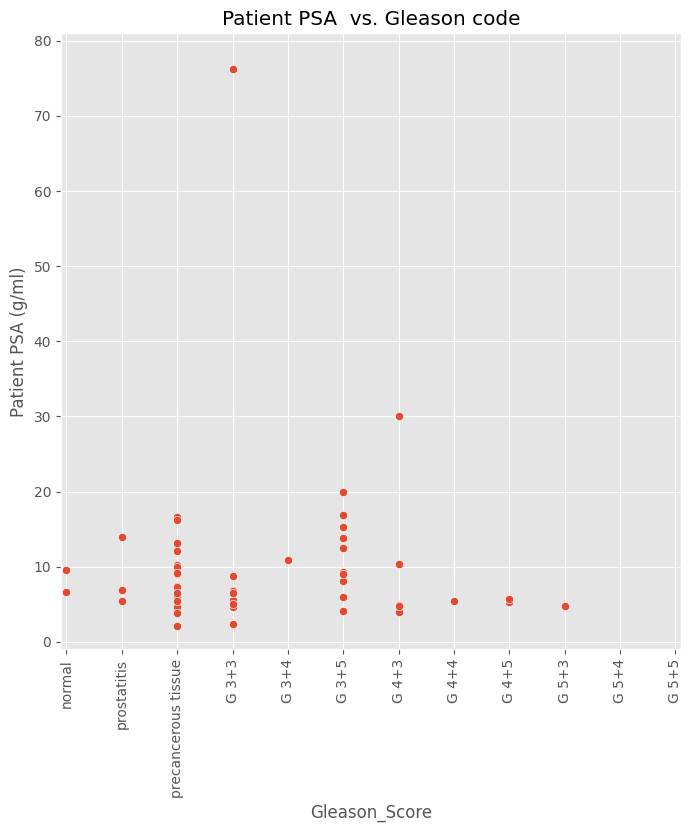

In [55]:
import seaborn as sns
from matplotlib import pyplot as plt


#Create the plot for PSA vs gleason:
PSA_vs_gleason_code = pd.DataFrame()
PSA_vs_gleason_code['Patient_PSA'] = patients_pirads['Patient_PSA']
PSA_vs_gleason_code['Gleason_code'] = patients_pirads['Gleason']
PSA_vs_gleason_code.index = patients_pirads['Unnamed: 0']
PSA_vs_gleason_code.dropna(axis=0,inplace=True)

code = {0 : 'normal' ,
            1 : 'prostatitis',
            2: 'precancerous tissue',
            3: 'G 3+3',
            4: 'G 3+4',
            5: 'G 3+5',
            6: 'G 4+3',
            7: 'G 4+4',
            8: 'G 4+5',
            9: 'G 5+3',
            10: 'G 5+4',
            11: 'G 5+5'}


PSA_vs_gleason_code['Gleason_Score'] = ''
for index in PSA_vs_gleason_code.index:
    PSA_vs_gleason_code.loc[index,'Gleason_Score'] = code[PSA_vs_gleason_code.loc[index,'Gleason_code']]
    if PSA_vs_gleason_code.loc[index,'Patient_PSA'] == 'missing':
        PSA_vs_gleason_code.drop(index,inplace=True)
#PSA_vs_gleason_code = PSA_vs_gleason_code.astype('float')

fig, ax = plt.subplots(figsize=(8,8))

ax = sns.scatterplot(data=PSA_vs_gleason_code, x="Gleason_Score", y="Patient_PSA")

ax.set_ylabel('Patient PSA (g/ml)')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11],labels=['normal' ,'prostatitis','precancerous tissue','G 3+3','G 3+4','G 3+5','G 4+3','G 4+4','G 4+5','G 5+3','G 5+4','G 5+5']
              ,rotation=90)
ax.set_ylim([-1, 81])
ax.set_xlim([-0.1, 11.1])
ax.set_title('Patient PSA  vs. Gleason code')

In [56]:
#Create heatmap table:
heatmap_Gleason_Score = pd.DataFrame(columns=[0,1,2,3,4,5,6,7,8,9,10,11])
heatmap_Gleason_Score.loc[3] = 0
heatmap_Gleason_Score.loc[4] = 0
heatmap_Gleason_Score.loc[5] = 0

for index in pirads_updated.index:
    heatmap_Gleason_Score.loc[pirads_updated.loc[index,'PIRADS'],pirads_updated.loc[index,'Gleason']] = heatmap_Gleason_Score.loc[pirads_updated.loc[index,'PIRADS'],pirads_updated.loc[index,'Gleason']] + 1

heatmap_Gleason_Score.rename(columns={0 : 'normal' ,
                                       1 : 'prostatitis',
                                       2: 'precancerous tissue',
                                       3: 'G 3+3',
                                       4: 'G 3+4',
                                       5: 'G 3+5',
                                       6: 'G 4+3',
                                       7: 'G 4+4',
                                       8: 'G 4+5',
                                       9: 'G 5+3',
                                       10: 'G 5+4',
                                       11: 'G 5+5'
                                       }, inplace=True)

heatmap_Gleason_Score


,normal,prostatitis,precancerous tissue,G 3+3,G 3+4,G 3+5,G 4+3,G 4+4,G 4+5,G 5+3,G 5+4,G 5+5
3,15,9,3,4,2,0,0,0,0,0,0,0
4,143,16,9,62,41,0,7,7,0,0,6,0
5,30,1,3,15,18,6,7,9,7,0,0,0


In [57]:
pirads_updated.loc[(pirads_updated['Annotator'] == 'rad1') & (pirads_updated['Annotation Process'] == 'ass')].shape

(77, 14)

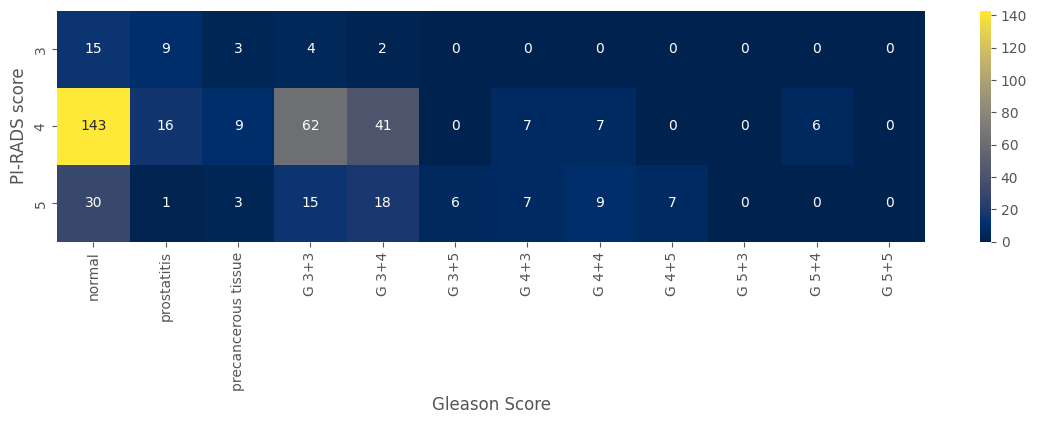

In [73]:
import seaborn as sns
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(14,3))

fig = sns.heatmap(heatmap_Gleason_Score,annot=True,fmt="0",cmap='cividis')

#plt.title('Gleason Scores vs PI-RADS scores of Lesions seen by all Readers')
plt.ylabel('PI-RADS score')
plt.xlabel('Gleason Score')

path = 'figures_general_calculation/heatmap_total.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

In [59]:
heatmap_Grade_Group_rad1_rad = pd.DataFrame(columns=[1,2,3,4,5])
heatmap_Grade_Group_rad1_rad.loc[5] = 0
heatmap_Grade_Group_rad1_rad.loc[4] = 0
heatmap_Grade_Group_rad1_rad.loc[3] = 0

heatmap_Grade_Group_rad1_ass = pd.DataFrame(columns=[1,2,3,4,5])
heatmap_Grade_Group_rad1_ass.loc[5] = 0
heatmap_Grade_Group_rad1_ass.loc[4] = 0
heatmap_Grade_Group_rad1_ass.loc[3] = 0

heatmap_Grade_Group_rad2_rad = pd.DataFrame(columns=[1,2,3,4,5])
heatmap_Grade_Group_rad2_rad.loc[5] = 0
heatmap_Grade_Group_rad2_rad.loc[4] = 0
heatmap_Grade_Group_rad2_rad.loc[3] = 0

heatmap_Grade_Group_rad2_ass = pd.DataFrame(columns=[1,2,3,4,5])
heatmap_Grade_Group_rad2_ass.loc[5] = 0
heatmap_Grade_Group_rad2_ass.loc[4] = 0
heatmap_Grade_Group_rad2_ass.loc[3] = 0

heatmap_Grade_Group_rad3_rad = pd.DataFrame(columns=[1,2,3,4,5])
heatmap_Grade_Group_rad3_rad.loc[5] = 0
heatmap_Grade_Group_rad3_rad.loc[4] = 0
heatmap_Grade_Group_rad3_rad.loc[3] = 0

heatmap_Grade_Group_rad3_ass = pd.DataFrame(columns=[1,2,3,4,5])
heatmap_Grade_Group_rad3_ass.loc[5] = 0
heatmap_Grade_Group_rad3_ass.loc[4] = 0
heatmap_Grade_Group_rad3_ass.loc[3] = 0


In [60]:
#Make the heatmap table with the Grade Group for all 3 readers and reader types:

for index in pirads_updated.index:

    if pirads_updated.loc[index,'Annotator'] == 'rad1' and pirads_updated.loc[index,'Annotation Process'] == 'rad':
        if pirads_updated.loc[index,'Gleason'] <= 3:
            heatmap_Grade_Group_rad1_rad.loc[pirads_updated.loc[index,'PIRADS'],1] = heatmap_Grade_Group_rad1_rad.loc[pirads_updated.loc[index,'PIRADS'],1] + 1

        if pirads_updated.loc[index,'Gleason'] == 4:
            heatmap_Grade_Group_rad1_rad.loc[pirads_updated.loc[index,'PIRADS'],2] = heatmap_Grade_Group_rad1_rad.loc[pirads_updated.loc[index,'PIRADS'],2] + 1

        if pirads_updated.loc[index,'Gleason'] == 6:
            heatmap_Grade_Group_rad1_rad.loc[pirads_updated.loc[index,'PIRADS'],3] = heatmap_Grade_Group_rad1_rad.loc[pirads_updated.loc[index,'PIRADS'],3] + 1        

        if pirads_updated.loc[index,'Gleason'] == 7 or pirads_updated.loc[index,'Gleason'] == 5 or pirads_updated.loc[index,'Gleason'] == 9:
            heatmap_Grade_Group_rad1_rad.loc[pirads_updated.loc[index,'PIRADS'],4] = heatmap_Grade_Group_rad1_rad.loc[pirads_updated.loc[index,'PIRADS'],4] + 1

        if pirads_updated.loc[index,'Gleason'] == 8 or pirads_updated.loc[index,'Gleason'] == 10 or pirads_updated.loc[index,'Gleason'] == 11:
            heatmap_Grade_Group_rad1_rad.loc[pirads_updated.loc[index,'PIRADS'],5] = heatmap_Grade_Group_rad1_rad.loc[pirads_updated.loc[index,'PIRADS'],5] + 1

    if pirads_updated.loc[index,'Annotator'] == 'rad1' and pirads_updated.loc[index,'Annotation Process'] == 'ass':
        if pirads_updated.loc[index,'Gleason'] <= 3:
            heatmap_Grade_Group_rad1_ass.loc[pirads_updated.loc[index,'PIRADS'],1] = heatmap_Grade_Group_rad1_ass.loc[pirads_updated.loc[index,'PIRADS'],1] + 1

        if pirads_updated.loc[index,'Gleason'] == 4:
            heatmap_Grade_Group_rad1_ass.loc[pirads_updated.loc[index,'PIRADS'],2] = heatmap_Grade_Group_rad1_ass.loc[pirads_updated.loc[index,'PIRADS'],2] + 1

        if pirads_updated.loc[index,'Gleason'] == 6:
            heatmap_Grade_Group_rad1_ass.loc[pirads_updated.loc[index,'PIRADS'],3] = heatmap_Grade_Group_rad1_ass.loc[pirads_updated.loc[index,'PIRADS'],3] + 1        

        if pirads_updated.loc[index,'Gleason'] == 7 or pirads_updated.loc[index,'Gleason'] == 5 or pirads_updated.loc[index,'Gleason'] == 9:
            heatmap_Grade_Group_rad1_ass.loc[pirads_updated.loc[index,'PIRADS'],4] = heatmap_Grade_Group_rad1_ass.loc[pirads_updated.loc[index,'PIRADS'],4] + 1

        if pirads_updated.loc[index,'Gleason'] == 8 or pirads_updated.loc[index,'Gleason'] == 10 or pirads_updated.loc[index,'Gleason'] == 11:
            heatmap_Grade_Group_rad1_ass.loc[pirads_updated.loc[index,'PIRADS'],5] = heatmap_Grade_Group_rad1_ass.loc[pirads_updated.loc[index,'PIRADS'],5] + 1

    if pirads_updated.loc[index,'Annotator'] == 'rad2' and pirads_updated.loc[index,'Annotation Process'] == 'rad':
        if pirads_updated.loc[index,'Gleason'] <= 3:
            heatmap_Grade_Group_rad2_rad.loc[pirads_updated.loc[index,'PIRADS'],1] = heatmap_Grade_Group_rad2_rad.loc[pirads_updated.loc[index,'PIRADS'],1] + 1

        if pirads_updated.loc[index,'Gleason'] == 4:
            heatmap_Grade_Group_rad2_rad.loc[pirads_updated.loc[index,'PIRADS'],2] = heatmap_Grade_Group_rad2_rad.loc[pirads_updated.loc[index,'PIRADS'],2] + 1

        if pirads_updated.loc[index,'Gleason'] == 6:
            heatmap_Grade_Group_rad2_rad.loc[pirads_updated.loc[index,'PIRADS'],3] = heatmap_Grade_Group_rad2_rad.loc[pirads_updated.loc[index,'PIRADS'],3] + 1        

        if pirads_updated.loc[index,'Gleason'] == 7 or pirads_updated.loc[index,'Gleason'] == 5 or pirads_updated.loc[index,'Gleason'] == 9:
            heatmap_Grade_Group_rad2_rad.loc[pirads_updated.loc[index,'PIRADS'],4] = heatmap_Grade_Group_rad2_rad.loc[pirads_updated.loc[index,'PIRADS'],4] + 1

        if pirads_updated.loc[index,'Gleason'] == 8 or pirads_updated.loc[index,'Gleason'] == 10 or pirads_updated.loc[index,'Gleason'] == 11:
            heatmap_Grade_Group_rad2_rad.loc[pirads_updated.loc[index,'PIRADS'],5] = heatmap_Grade_Group_rad2_rad.loc[pirads_updated.loc[index,'PIRADS'],5] + 1

    if pirads_updated.loc[index,'Annotator'] == 'rad2' and pirads_updated.loc[index,'Annotation Process'] == 'ass':
        if pirads_updated.loc[index,'Gleason'] <= 3:
            heatmap_Grade_Group_rad2_ass.loc[pirads_updated.loc[index,'PIRADS'],1] = heatmap_Grade_Group_rad2_ass.loc[pirads_updated.loc[index,'PIRADS'],1] + 1

        if pirads_updated.loc[index,'Gleason'] == 4:
            heatmap_Grade_Group_rad2_ass.loc[pirads_updated.loc[index,'PIRADS'],2] = heatmap_Grade_Group_rad2_ass.loc[pirads_updated.loc[index,'PIRADS'],2] + 1

        if pirads_updated.loc[index,'Gleason'] == 6:
            heatmap_Grade_Group_rad2_ass.loc[pirads_updated.loc[index,'PIRADS'],3] = heatmap_Grade_Group_rad2_ass.loc[pirads_updated.loc[index,'PIRADS'],3] + 1        

        if pirads_updated.loc[index,'Gleason'] == 7 or pirads_updated.loc[index,'Gleason'] == 5 or pirads_updated.loc[index,'Gleason'] == 9:
            heatmap_Grade_Group_rad2_ass.loc[pirads_updated.loc[index,'PIRADS'],4] = heatmap_Grade_Group_rad2_ass.loc[pirads_updated.loc[index,'PIRADS'],4] + 1

        if pirads_updated.loc[index,'Gleason'] == 8 or pirads_updated.loc[index,'Gleason'] == 10 or pirads_updated.loc[index,'Gleason'] == 11:
            heatmap_Grade_Group_rad2_ass.loc[pirads_updated.loc[index,'PIRADS'],5] = heatmap_Grade_Group_rad2_ass.loc[pirads_updated.loc[index,'PIRADS'],5] + 1

    if pirads_updated.loc[index,'Annotator'] == 'rad3' and pirads_updated.loc[index,'Annotation Process'] == 'rad':
        if pirads_updated.loc[index,'Gleason'] <= 3:
            heatmap_Grade_Group_rad3_rad.loc[pirads_updated.loc[index,'PIRADS'],1] = heatmap_Grade_Group_rad3_rad.loc[pirads_updated.loc[index,'PIRADS'],1] + 1

        if pirads_updated.loc[index,'Gleason'] == 4:
            heatmap_Grade_Group_rad3_rad.loc[pirads_updated.loc[index,'PIRADS'],2] = heatmap_Grade_Group_rad3_rad.loc[pirads_updated.loc[index,'PIRADS'],2] + 1

        if pirads_updated.loc[index,'Gleason'] == 6:
            heatmap_Grade_Group_rad3_rad.loc[pirads_updated.loc[index,'PIRADS'],3] = heatmap_Grade_Group_rad3_rad.loc[pirads_updated.loc[index,'PIRADS'],3] + 1        

        if pirads_updated.loc[index,'Gleason'] == 7 or pirads_updated.loc[index,'Gleason'] == 5 or pirads_updated.loc[index,'Gleason'] == 9:
            heatmap_Grade_Group_rad3_rad.loc[pirads_updated.loc[index,'PIRADS'],4] = heatmap_Grade_Group_rad3_rad.loc[pirads_updated.loc[index,'PIRADS'],4] + 1

        if pirads_updated.loc[index,'Gleason'] == 8 or pirads_updated.loc[index,'Gleason'] == 10 or pirads_updated.loc[index,'Gleason'] == 11:
            heatmap_Grade_Group_rad3_rad.loc[pirads_updated.loc[index,'PIRADS'],5] = heatmap_Grade_Group_rad3_rad.loc[pirads_updated.loc[index,'PIRADS'],5] + 1

    if pirads_updated.loc[index,'Annotator'] == 'rad3' and pirads_updated.loc[index,'Annotation Process'] == 'ass':
        if pirads_updated.loc[index,'Gleason'] <= 3:
            heatmap_Grade_Group_rad3_ass.loc[pirads_updated.loc[index,'PIRADS'],1] = heatmap_Grade_Group_rad3_ass.loc[pirads_updated.loc[index,'PIRADS'],1] + 1

        if pirads_updated.loc[index,'Gleason'] == 4:
            heatmap_Grade_Group_rad3_ass.loc[pirads_updated.loc[index,'PIRADS'],2] = heatmap_Grade_Group_rad3_ass.loc[pirads_updated.loc[index,'PIRADS'],2] + 1

        if pirads_updated.loc[index,'Gleason'] == 6:
            heatmap_Grade_Group_rad3_ass.loc[pirads_updated.loc[index,'PIRADS'],3] = heatmap_Grade_Group_rad3_ass.loc[pirads_updated.loc[index,'PIRADS'],3] + 1        

        if pirads_updated.loc[index,'Gleason'] == 7 or pirads_updated.loc[index,'Gleason'] == 5 or pirads_updated.loc[index,'Gleason'] == 9:
            heatmap_Grade_Group_rad3_ass.loc[pirads_updated.loc[index,'PIRADS'],4] = heatmap_Grade_Group_rad3_ass.loc[pirads_updated.loc[index,'PIRADS'],4] + 1

        if pirads_updated.loc[index,'Gleason'] == 8 or pirads_updated.loc[index,'Gleason'] == 10 or pirads_updated.loc[index,'Gleason'] == 11:
            heatmap_Grade_Group_rad3_ass.loc[pirads_updated.loc[index,'PIRADS'],5] = heatmap_Grade_Group_rad3_ass.loc[pirads_updated.loc[index,'PIRADS'],5] + 1



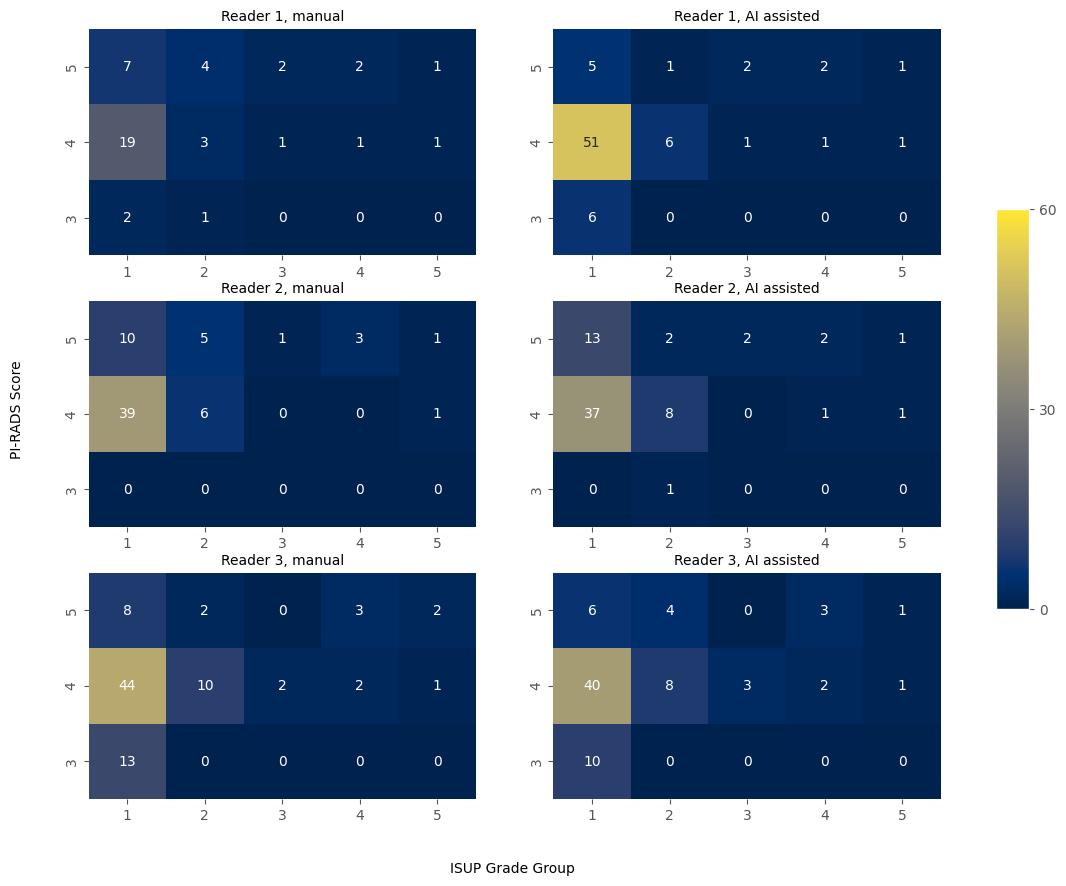

In [74]:
#Create the according figure:

heatmaps = [heatmap_Grade_Group_rad1_rad,
            heatmap_Grade_Group_rad1_ass,
            heatmap_Grade_Group_rad2_rad,
            heatmap_Grade_Group_rad2_ass,
            heatmap_Grade_Group_rad3_rad,
            heatmap_Grade_Group_rad3_ass]


fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2, figsize = (11,10),)


ax1 = sns.heatmap(ax = ax1,data=heatmap_Grade_Group_rad1_rad,annot=True,fmt="0",cbar=False,cmap='cividis',vmax=60,vmin=0)
ax1.set_title('Reader 1, manual',size=10)
ax2 = sns.heatmap(ax = ax2,data=heatmap_Grade_Group_rad1_ass,annot=True,fmt="0",cbar=False,cmap='cividis',vmax=60,vmin=0)
ax2.set_title('Reader 1, AI assisted',size=10)
ax3 = sns.heatmap(ax = ax3,data=heatmap_Grade_Group_rad2_rad,annot=True,fmt="0",cbar=False,cmap='cividis',vmax=60,vmin=0)
ax3.set_title('Reader 2, manual',size=10)
ax4 = sns.heatmap(ax = ax4,data=heatmap_Grade_Group_rad2_ass,annot=True,fmt="0",cbar=False,cmap='cividis',vmax=60,vmin=0)
ax4.set_title('Reader 2, AI assisted',size=10)
ax5 = sns.heatmap(ax = ax5,data=heatmap_Grade_Group_rad3_rad,annot=True,fmt="0",cbar=False,cmap='cividis',vmax=60,vmin=0)
ax5.set_title('Reader 3, manual',size=10)
ax6 = sns.heatmap(ax = ax6,data=heatmap_Grade_Group_rad3_ass,annot=True,fmt="0",cbar=False,cmap='cividis',vmax=60,vmin=0)
ax6.set_title('Reader 3, AI assisted',size=10)

#make a single colorbar and remove its ticks:
ax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])

#make the image of the colorbar:
im = ax.imshow(255 * np.ones((1,60,3), np.uint8), cmap='cividis', 
                   vmin=0, vmax=1)
cb_ax = fig.add_axes([0.95, 0.3, 0.03, 0.4])
cbar = fig.colorbar(im, cax=cb_ax)

#set the colorbar ticks and tick labels
cbar.set_ticks(np.arange(0, 1.1, 0.5))
cbar.set_ticklabels([0, 30, 60])


#plt.suptitle('ISUP Grade vs PI-RADS Scores of Lesions')
fig.text(0.51, 0.04, 'ISUP Grade Group', ha='center', va='center')
fig.text(0.06, 0.5, 'PI-RADS Score', ha='center', va='center', rotation='vertical')

path = 'figures_general_calculation/heatmap_split_readers.svg'
plt.savefig(path, format='svg',bbox_inches='tight')

In [62]:
# Plot the Piqual scores for the selected cases:
piquals =  pd.read_excel("C:/Users/Joel Fischer/Documents/Masterarbeit/Studie/Projekt/Auswertungsdaten/20230814_KSA-study_Image-Quality_Master.xlsx")

piquals_selected_cases = piquals.copy()
piquals_selected_cases.index = piquals_selected_cases['Case']

for Case in piquals_selected_cases.index:
    Case_name = Case.split('-')[0] + '_' + Case.split('-')[1]
    if Case_name not in list(translation['Case']) or Case_name == 'bell_0027':

        piquals_selected_cases.drop(Case,inplace=True)

#bell_0045 is missing the piqual data!

In [63]:
piqual_table = pd.DataFrame(columns=[1,2,3,4,5],index=['Bellinzona','Aarau','Triemli'])
piqual_table.loc['Bellinzona'] = 0
piqual_table.loc['Aarau'] = 0
piqual_table.loc['Triemli'] = 0

for Case in piquals_selected_cases.index:
    if Case.split('-')[0] == 'bell':
        piqual_table.loc['Bellinzona',piquals_selected_cases.loc[Case,'Image quality PI-QUAL']] = piqual_table.loc['Bellinzona',piquals_selected_cases.loc[Case,'Image quality PI-QUAL']] + 1
    if Case.split('-')[0] == 'ksa3':
        piqual_table.loc['Aarau',piquals_selected_cases.loc[Case,'Image quality PI-QUAL']] = piqual_table.loc['Aarau',piquals_selected_cases.loc[Case,'Image quality PI-QUAL']] + 1
    if Case.split('-')[0] == 'tri':
        piqual_table.loc['Triemli',piquals_selected_cases.loc[Case,'Image quality PI-QUAL']] = piqual_table.loc['Triemli',piquals_selected_cases.loc[Case,'Image quality PI-QUAL']] + 1   

     

In [ ]:
piqual_table

,1,2,3,4,5
Bellinzona,0,0,11,0,0
Aarau,0,0,0,1,33
Triemli,0,0,0,6,15
